In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

pd.set_option("display.max_columns", 500)
plt.style.use("seaborn-colorblind")
pal = sns.color_palette()

C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_18648\760691403.py:8: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



In [20]:
# Read the data from the csv file
column_subset = [
    "FlightDate",
    "Airline",
    "Flight_Number_Marketing_Airline",
    "Origin",
    "Dest",
    "Cancelled",
    "Diverted",
    "CRSDepTime",
    "DepTime",
    "DepDelayMinutes",
    "OriginAirportID",
    "OriginCityName",
    "OriginStateName",
    "DestAirportID",
    "DestCityName",
    "DestStateName",
    "TaxiOut",
    "TaxiIn",
    "CRSArrTime",
    "ArrTime",
    "ArrDelayMinutes",
]


dfs = []

# Iterate over csv files in the specified directory
for f in glob('dataset/visualize/*.csv'):
    try:
        df = pd.read_csv(f, usecols=column_subset)
        dfs.append(df)
    except Exception as e:
        print(f"Error reading file {f}: {e}")

# Concatenate the DataFrames
if dfs:
    df = pd.concat(dfs).reset_index(drop=True)
    #
    cat_cols = ["Airline", "Origin", "Dest", "OriginStateName", "DestStateName"]
    
    # Convert specified columns to categorical data types
    for c in cat_cols:
        df[c] = df[c].astype("category")
else:
    print("No valid csv files found in the specified directory.")

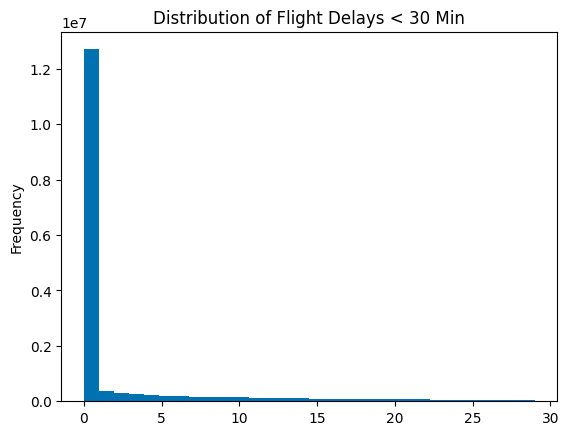

In [21]:
# Depature delay
df.query("DepDelayMinutes < 30")["DepDelayMinutes"].plot(
    kind="hist", bins=30, title="Distribution of Flight Delays < 30 Min"
)
plt.show()

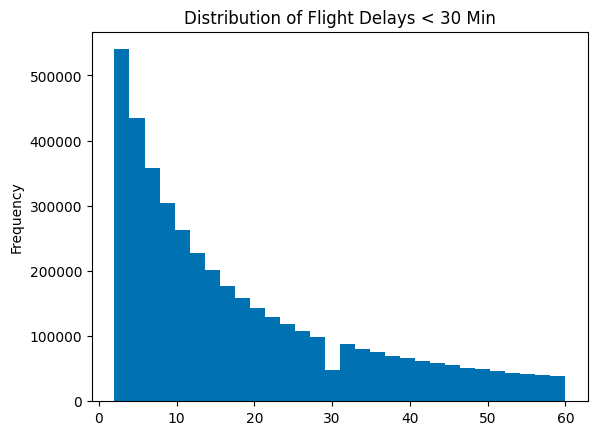

In [22]:
df.query("DepDelayMinutes > 1 and DepDelayMinutes < 61")["DepDelayMinutes"].plot(
    kind="hist", bins=30, title="Distribution of Flight Delays < 30 Min"
)
plt.show()

In [23]:
# Group delays
df["DelayGroup"] = None
df.loc[df["DepDelayMinutes"] == 0, "DelayGroup"] = "OnTime_Early"
df.loc[
    (df["DepDelayMinutes"] > 0) & (df["DepDelayMinutes"] <= 15), "DelayGroup"
] = "Small_Delay"
df.loc[
    (df["DepDelayMinutes"] > 15) & (df["DepDelayMinutes"] <= 45), "DelayGroup"
] = "Medium_Delay"
df.loc[df["DepDelayMinutes"] > 45, "DelayGroup"] = "Large_Delay"
df.loc[df["Cancelled"], "DelayGroup"] = "Cancelled"

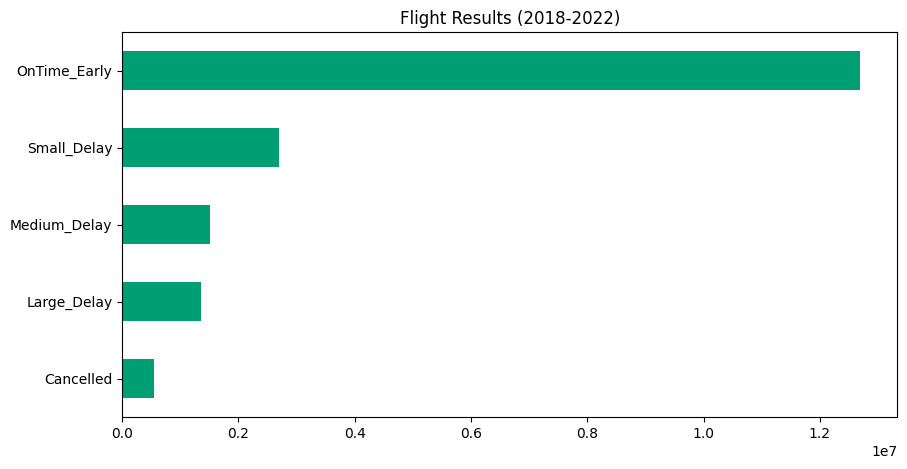

In [24]:
df["DelayGroup"].value_counts(ascending=True).plot(
    kind="barh", figsize=(10, 5), color=pal[1], title="Flight Results (2018-2022)"
)
plt.show()

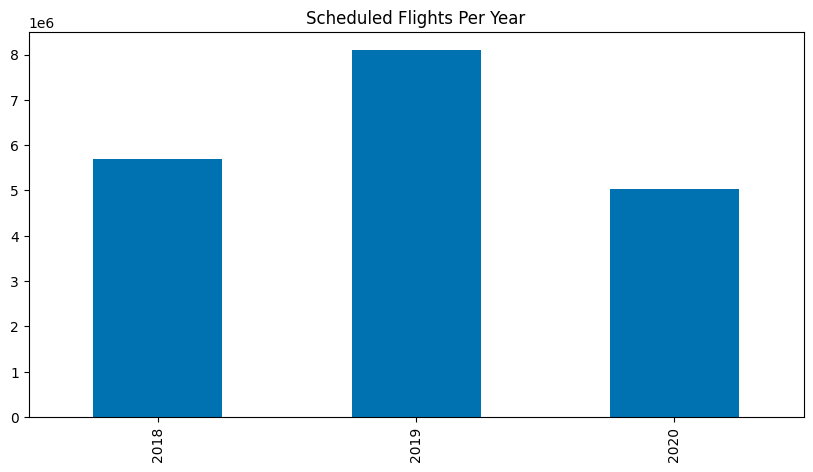

In [25]:
# Schedule flight
# Assuming already have DataFrame 'df' with the 'FlightDate' column
# If 'FlightDate' is not already in datetime format, convert it
if not pd.api.types.is_datetime64_any_dtype(df['FlightDate']):
    df['FlightDate'] = pd.to_datetime(df['FlightDate'], errors='coerce')

# Now can create the 'Year' column and plot the data
df["Year"] = df['FlightDate'].dt.year

# Count the number of flights per year and sort by the year
flight_counts = df["Year"].value_counts().sort_index()

# Create a bar plot
flight_counts.plot(
    kind="bar", figsize=(10, 5), title="Scheduled Flights Per Year"
)

# Show the plot
plt.show()

In [26]:
# Delay per year
df["Year"] = df["FlightDate"].dt.year
df_agg = df.groupby("Year")["DelayGroup"].value_counts(normalize=True).unstack() * 100
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Greens")

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Year,,,,,
2018,64.115615,16.474583,9.538448,8.317789,1.553565
2019,64.619787,15.716778,9.081583,8.683248,1.898604
2020,76.052291,9.653418,4.572319,3.727722,5.994249


In [27]:
# Delay per month
df["Month"] = df["FlightDate"].dt.month
df_agg = df.groupby("Month")["DelayGroup"].value_counts(normalize=True).unstack() * 100
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Blues")

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Month,,,,,
1,67.545603,14.727827,8.208936,7.202903,2.314731
2,64.979168,15.556101,9.154347,8.302751,2.007633
3,65.834056,13.149916,7.159741,5.749939,8.106346
4,62.960426,12.689449,7.152088,6.579497,10.618540
5,65.482827,15.071634,8.681506,8.277145,2.486887
6,62.718937,16.189361,9.701515,9.789234,1.600952
7,66.709760,14.546530,8.447804,8.650790,1.645117
8,67.151167,14.084766,8.326763,8.652905,1.784399
9,74.047712,12.398425,6.375926,5.774267,1.403670


In [28]:
df["Month"] = df["FlightDate"].dt.month
df_agg = (
    df.query("Year != 2020")
    .groupby("Month")["DelayGroup"]
    .value_counts(normalize=True)
    .unstack()
    * 100
)
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Blues")

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Month,,,,,
1,65.294790,15.038778,8.762902,7.961513,2.942017
2,60.265477,16.980252,10.599116,9.393811,2.761344
3,64.476270,16.823827,9.186142,7.340492,2.173268
4,65.841288,15.485263,8.797321,8.094137,1.781991
5,62.339913,16.615136,9.816968,9.456938,1.771045
6,57.784979,17.729653,11.123022,11.487878,1.874469
7,60.870363,16.669770,10.029459,10.492633,1.937775
8,61.563207,16.006083,9.866371,10.552001,2.012338
9,71.057808,13.459408,7.215676,6.684454,1.582653


In [29]:
df["Month"] = df["FlightDate"].dt.month
df_agg = (
    df.query("3 <= Month <= 4")
    .groupby("Year")["DelayGroup"]
    .value_counts(normalize=True)
    .unstack()
    * 100
)
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Oranges", axis=0)

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Year,,,,,
2018,64.219260,17.194531,9.582907,7.347652,1.655651
2019,65.790141,15.462990,8.614418,7.974924,2.157527
2020,63.063286,6.202543,3.291875,2.733237,24.709059


Text(0.5, 0.92, 'US Flight Cancellations')

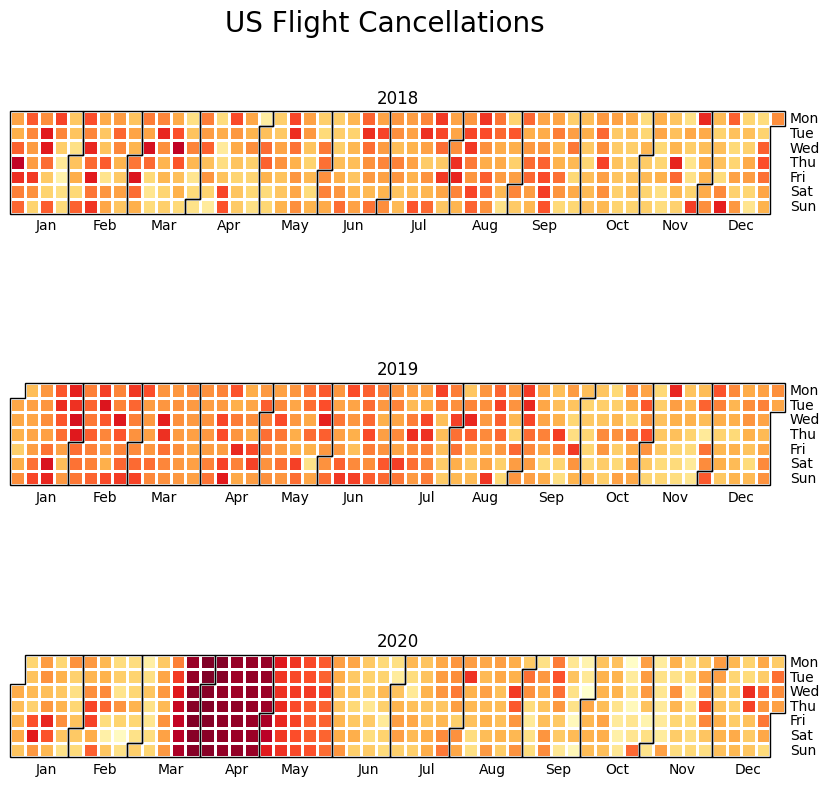

In [30]:
import calmap

# Flight cancelation
events = df.groupby("FlightDate")["Cancelled"].mean()
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for i, year in enumerate([2018, 2019, 2020]):
    calmap.yearplot(
        events.apply(np.log), year=year, cmap="YlOrRd", monthly_border=True, ax=axs[i]
    )
    axs[i].set_title(year)
fig.patch.set_facecolor("white")
fig.suptitle("US Flight Cancellations", y=0.92, fontsize=20)

In [31]:
from plotly_calplot import calplot

# creating the plot
fig = calplot(events.apply(np.log).reset_index(), x="FlightDate", y="Cancelled")
fig.show()

Text(0.5, 0, 'Flights (100k)')

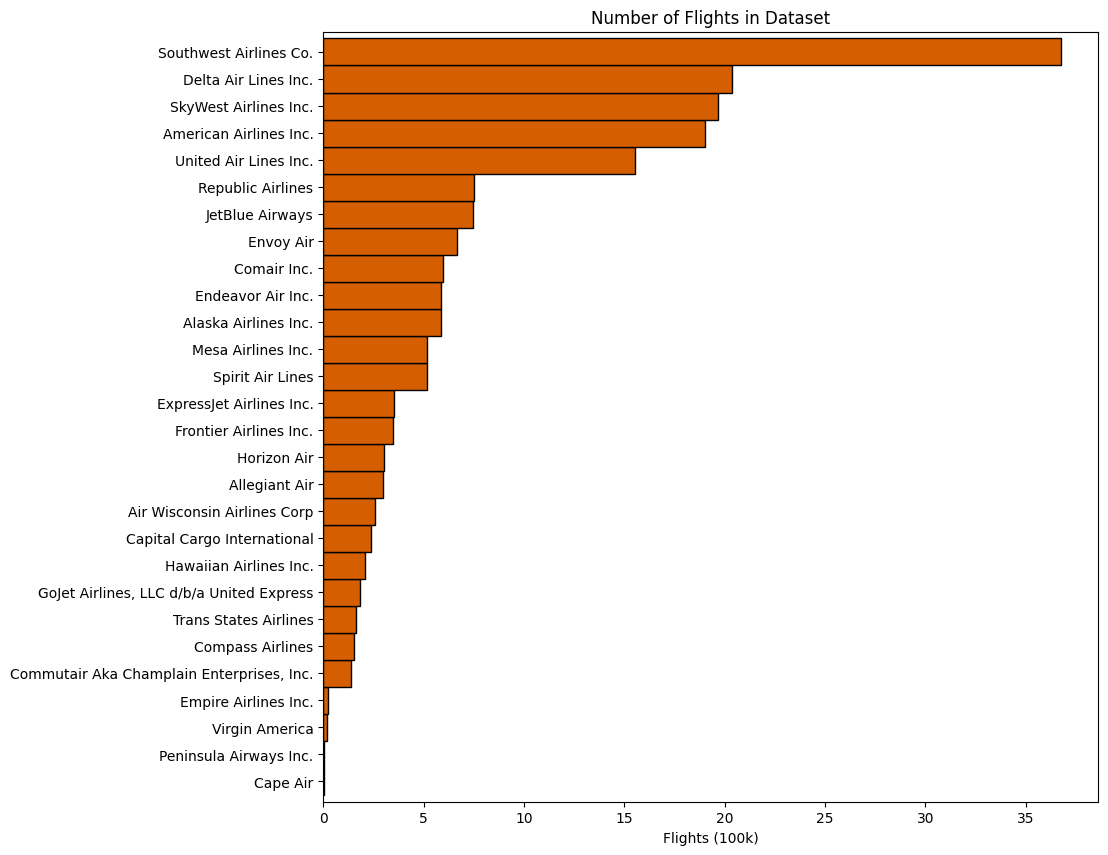

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
airlines_ordered = (df["Airline"].value_counts(ascending=True) / 100_000).plot(
    kind="barh", ax=ax, color=pal[2], width=1, edgecolor="black"
)
ax.set_title("Number of Flights in Dataset")
ax.set_xlabel("Flights (100k)")

In [33]:
top_airlines = (
    df["Airline"]
    .value_counts()
    .reset_index()
    .query("Airline > 1_000_000")["index"]
    .values.tolist()
)

df_top = df.loc[df["Airline"].isin(top_airlines)].reset_index(drop=True).copy()

In [34]:
# Reset airline categories
df_top["Airline"] = df_top["Airline"].astype("str").astype("category")

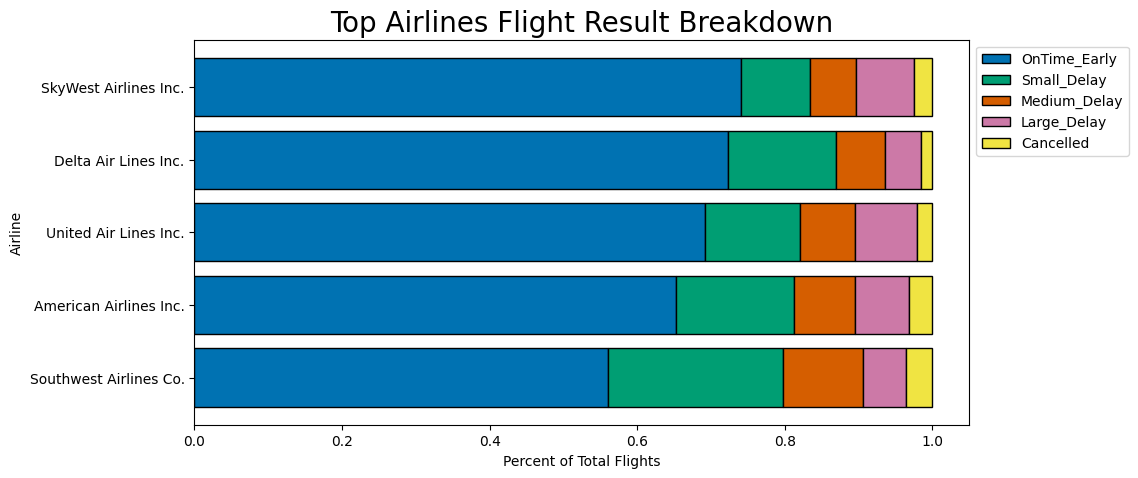

In [35]:
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]

df_agg = (
    df_top.groupby(["Airline"])["DelayGroup"]
    .value_counts(normalize=True)
    .unstack()[col_order]
)

fig, ax = plt.subplots(figsize=(10, 5))
df_agg.sort_values("OnTime_Early").plot(
    kind="barh", stacked=True, ax=ax, width=0.8, edgecolor="black"
)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title("Top Airlines Flight Result Breakdown", fontsize=20)
ax.set_xlabel("Percent of Total Flights")
plt.show()

In [36]:
delay_mapping = {
    "OnTime_Early": "Good",
    "Small_Delay": "Good",
    "Medium_Delay": "Bad",
    "Large_Delay": "Bad",
    "Cancelled": "Bad",
}

In [37]:
df_top["DelayOk"] = df_top["DelayGroup"].map(delay_mapping)

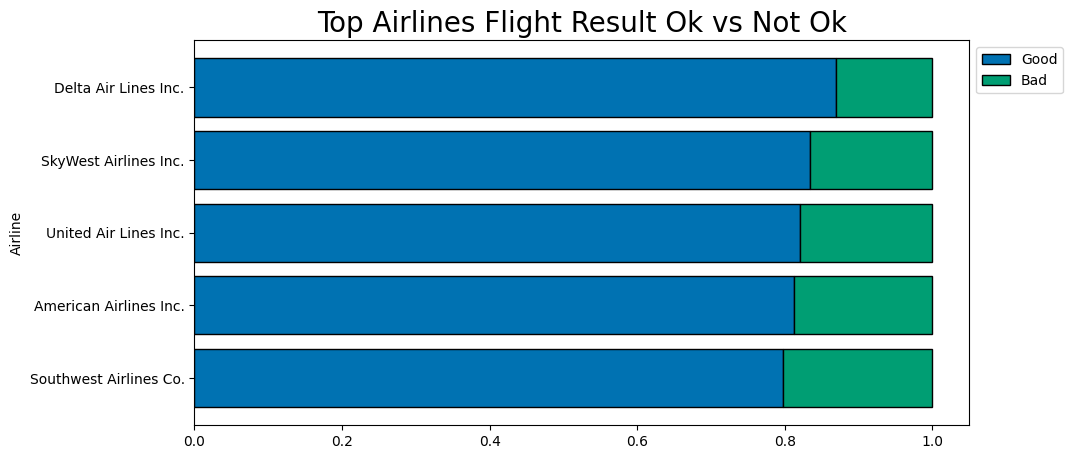

In [38]:
df_agg = (
    df_top.groupby(["Airline"])["DelayOk"]
    .value_counts(normalize=True)
    .unstack()[["Good", "Bad"]]
)

fig, ax = plt.subplots(figsize=(10, 5))
df_agg.sort_values("Good").plot(
    kind="barh", stacked=True, ax=ax, width=0.8, edgecolor="black"
)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title("Top Airlines Flight Result Ok vs Not Ok", fontsize=20)

plt.show()